# LSTM을 활용한 주가 예측 모델

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
import random

import torch
import torch.nn as nn
import torch.optim as optim

import keyring
import requests as rq
from io import BytesIO
import zipfile
import xmltodict
import json
import pandas as pd
from sqlalchemy import create_engine
import pymysql
from datetime import date
from dateutil.relativedelta import relativedelta
from tqdm import tqdm


In [2]:
ip =  '3.35.174.150'

In [6]:

engine = create_engine(f'mysql+pymysql://jun:1234qwer@{ip}:3306/quant')
con = pymysql.connect(user='jun',
                      passwd='1234qwer',
                      host= ip,
                      db='quant',
                      charset='utf8')
mycursor = con.cursor()

In [86]:
sql_query = """
SELECT * FROM df
"""

# con을 사용하여 데이터를 읽음
stock_price = pd.read_sql_query(sql_query, con)

/var/folders/2r/1jlbwmkx17lfppyzf58k985c0000gn/T/ipykernel_88464/572412913.py:6: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  stock_price = pd.read_sql_query(sql_query, con)


In [119]:
stock_price

,open,high,low,close,volume,stock_code,stock_name
date,,,,,,,
2018-09-20,6810.0,7120.0,6670.0,7030.0,181397.0,95570,AJ네트웍스
2018-09-21,7110.0,7130.0,6270.0,6490.0,359049.0,95570,AJ네트웍스
2018-09-27,6600.0,6600.0,6220.0,6360.0,210740.0,95570,AJ네트웍스
2018-09-28,6530.0,6530.0,5980.0,6160.0,171325.0,95570,AJ네트웍스
2018-10-01,6160.0,6350.0,6050.0,6180.0,77744.0,95570,AJ네트웍스
...,...,...,...,...,...,...,...
2023-09-14,6330.0,7170.0,6300.0,6610.0,240627.0,238490,힘스
2023-09-15,6640.0,6670.0,6520.0,6610.0,28387.0,238490,힘스
2023-09-18,6610.0,6610.0,6350.0,6400.0,29544.0,238490,힘스


In [88]:
stock_price = stock_price.drop(columns=['index']) 

In [89]:
stock_price['date'] = pd.to_datetime(stock_price['date'])

In [90]:
stock_price.set_index('date', inplace=True)

In [91]:
stock_price = stock_price.astype({'stock_code': 'int'})

In [105]:
samsung = stock_price[stock_price['stock_name'] == '삼성전자']

In [106]:
samsung.head()

,open,high,low,close,volume,stock_code,stock_name
date,,,,,,,
2018-09-20,46850.0,47600.0,46400.0,47250.0,13537000.0,5930,삼성전자
2018-09-21,46550.0,47550.0,46550.0,47400.0,14476900.0,5930,삼성전자
2018-09-27,46950.0,47500.0,46450.0,47500.0,15804600.0,5930,삼성전자
2018-09-28,47250.0,47250.0,46300.0,46450.0,11270500.0,5930,삼성전자
2018-10-01,46450.0,46800.0,45800.0,46350.0,6354980.0,5930,삼성전자


In [94]:
seed = 2023
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

**FinanceDataReader**는 주가 데이터를 편리하게 가져올 수 있는 파이썬 패키지입니다.

- [GitHub Repo](https://github.com/FinanceData/FinanceDataReader)

### 컬럼 설명

- `종가`:   종가

## 시각화

In [21]:
plt.rcParams['font.family'] = 'Apple SD Gothic Neo'

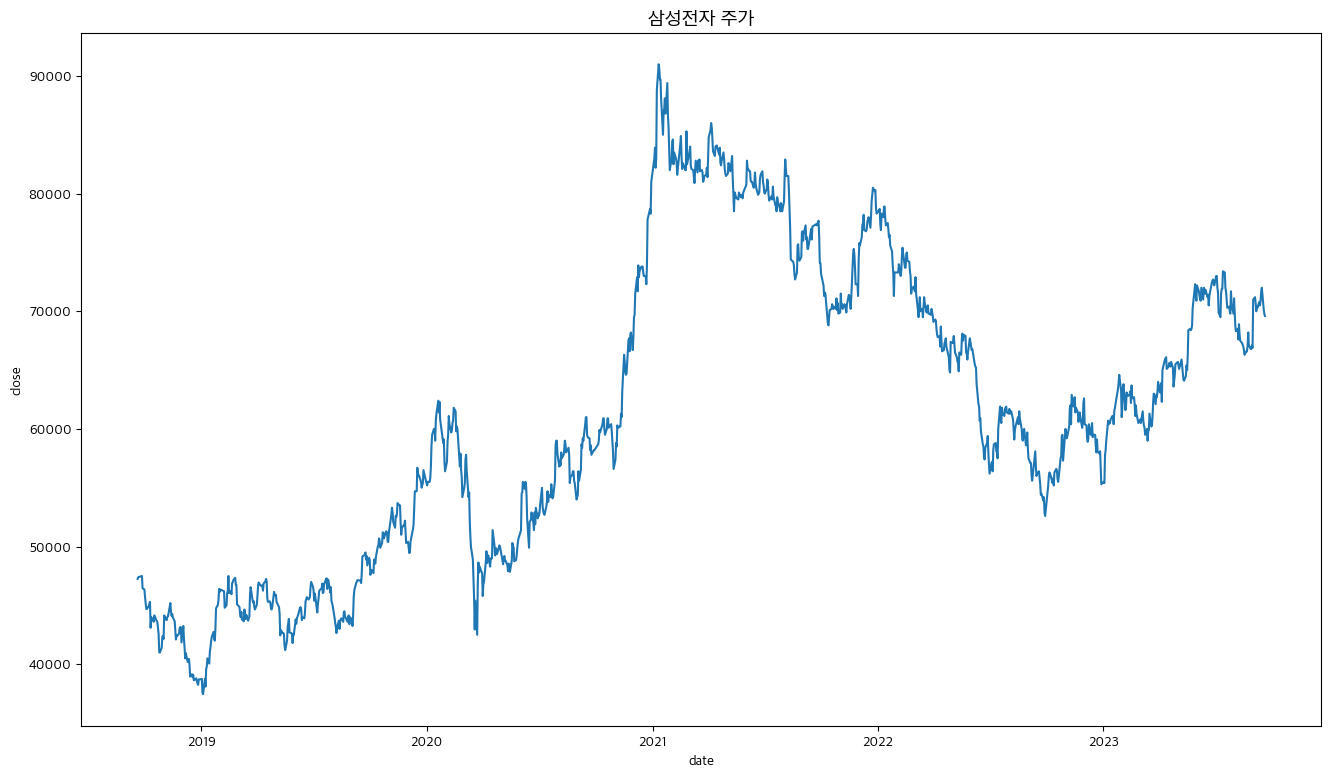

In [22]:
plt.figure(figsize=(16, 9))
plt.title("삼성전자 주가", fontsize=14)
plt.xlabel("date")
plt.ylabel("close")
sns.lineplot(data=samsung, x='date', y="close")
plt.show()

## 데이터 전처리

주가 데이터에 대하여 딥러닝 모델이 더 잘 학습할 수 있도록 **정규화(Normalization)**를 해주도록 하겠습니다.

**표준화 (Standardization)**와 **정규화(Normalization)**에 대한 내용은 아래 링크에서 더 자세히 다루니, 참고해 보시기 바랍니다.

- [데이터 전처리에 관하여](https://teddylee777.github.io/scikit-learn/scikit-learn-preprocessing)

In [107]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
y_scaler = MinMaxScaler()
# 스케일을 적용할 column을 정의합니다.
scale_cols = columns = ['open', 'high', 'low', 'close', 'volume']

#scale_cols = ['Close']
# 스케일 후 columns
scaled = scaler.fit_transform(samsung[scale_cols])
y_scaler.fit(samsung[["close"]]) ## 나중에 그림그릴 때 inverse하려고
scaled

array([[0.17786187, 0.16891892, 0.18138651, 0.18300654, 0.10629226],
       [0.17218543, 0.16807432, 0.18423552, 0.18580766, 0.11723409],
       [0.17975402, 0.16722973, 0.18233618, 0.18767507, 0.1326905 ],
       ...,
       [0.64049196, 0.57601351, 0.6334283 , 0.61157796, 0.13543905],
       [0.62346263, 0.56081081, 0.62203229, 0.60410831, 0.08630615],
       [0.61589404, 0.55236486, 0.62013295, 0.60037348, 0.07141552]])

스케일이 완료된 column으로 새로운 데이터프레임을 생성합니다.

**시간 순으로 정렬**되어 있으며, datetime index는 제외했습니다.

*6,000개의 row, 5개 column*으로 이루어진 데이터셋이 DataFrame으로 정리되었습니다.

In [108]:
scaled_df = pd.DataFrame(scaled, columns=scale_cols, index=samsung.index)


In [109]:
scaled_df['stock_code'] = samsung['stock_code']

In [110]:
samsung = scaled_df

In [111]:
samsung

,open,high,low,close,volume,stock_code
date,,,,,,
2018-09-20,0.177862,0.168919,0.181387,0.183007,0.106292,5930
2018-09-21,0.172185,0.168074,0.184236,0.185808,0.117234,5930
2018-09-27,0.179754,0.167230,0.182336,0.187675,0.132690,5930
2018-09-28,0.185430,0.163007,0.179487,0.168067,0.079907,5930
2018-10-01,0.170293,0.155405,0.169991,0.166200,0.022683,5930
...,...,...,...,...,...,...
2023-09-14,0.638600,0.577703,0.644824,0.639589,0.193655,5930
2023-09-15,0.648061,0.586149,0.656220,0.645191,0.156193,5930
2023-09-18,0.640492,0.576014,0.633428,0.611578,0.135439,5930


In [18]:
# scaled_df[['날짜', '종목코드', '종목명', 'SEC_NM_KOR']] = df[['날짜', '종목코드', '종목명', 'SEC_NM_KOR']]


In [20]:
# df =scaled_df

In [ ]:
# df.tail(5)

## train / val / test 분할

- 2022년 이전까지의 모든 데이터로, 2022년을 val으로, 2023년을 test로.


- 시계열 예측에서는 "예측 당시"에는 미래의 데이터를 모릅니다. 그래서 train 데이터는 무조건 test 데이터보다 시기적으로 **과거**여야합니다.

In [114]:
X_train

,open,high,low,volume,stock_code
date,,,,,
2020-01-02,0.341533,0.310811,0.344729,0.099962,5930
2020-01-03,0.350993,0.320946,0.342830,0.128240,5930
2020-01-06,0.330180,0.304054,0.337132,0.068364,5930
2020-01-07,0.345317,0.317568,0.356125,0.065230,5930
2020-01-08,0.354778,0.334459,0.361823,0.222290,5930
...,...,...,...,...,...
2021-12-24,0.808893,0.729730,0.823362,0.089405,5930
2021-12-27,0.816462,0.726351,0.815764,0.074236,5930
2021-12-28,0.808893,0.722973,0.813865,0.160883,5930


In [117]:
train = samsung.loc[(samsung.index > '2020-01-01') & (samsung.index < '2022-01-01')]
X_train, y_train = train.drop(["close", "open", "high", "low", "volume"], axis=1), train['close']

test = samsung.loc[samsung.index >= '2022-01-01']
X_test, y_test = test.drop(["close", "open", "high", "low", "volume"], axis=1), test['close']

## Data Preparation

In [118]:
from torch.utils.data import TensorDataset # 텐서데이터셋
from torch.utils.data import DataLoader # 데이터로더

seq_length =10 #hidden_state 개수
batch_size =8   #(batch_size,seq_len,input_dim)

# 데이터셋 생성 함수
def build_dataset(inputs, seq_length):
    dataX = []
    dataY = []
    for i in range(0, len(inputs)-seq_length):
        _x = inputs[i:i+seq_length, :]
        _y = inputs[i+seq_length, [-1]]
        #print(_x, "-->",_y)
        dataX.append(_x)
        dataY.append(_y)

    return np.array(dataX), np.array(dataY)

trainX, trainY =build_dataset(X_train.values,seq_length)
testX, testY =build_dataset(X_test.values,seq_length)

# 텐서로 변환
trainX_tensor = torch.FloatTensor(trainX)
trainY_tensor = torch.FloatTensor(trainY)

testX_tensor = torch.FloatTensor(testX)
testY_tensor = torch.FloatTensor(testY)

# 텐서 형태로 데이터 정의
dataset = TensorDataset(trainX_tensor, trainY_tensor)

# 데이터로더는 기본적으로 2개의 인자를 입력받으며 배치크기는 통상적으로 2의 배수를 사용
dataloader = DataLoader(dataset,
                        batch_size=batch_size,
                        shuffle=False,
                        drop_last=True)  #data개수가 batch개수로 깔끔하게 안나누어떨어질때 마지막 batch버리는것

## Define Model

In [57]:
class LSTM(nn.Module):
    # # 기본변수, layer를 초기화해주는 생성자
    def __init__(self, input_dim, hidden_dim, seq_len, output_dim, layers):
        super().__init__()
        self.hidden_dim=hidden_dim
        self.seq_len=seq_len
        self.output_dim=output_dim
        self.layers=layers

        self.lstm1=nn.LSTM(input_dim,hidden_dim,num_layers=layers,dropout=0.1,batch_first=True) #(8,10,4). ##LSTM layer
       #self.lstm2=nn.LSTM(hidden_dim,5) #multi-layer LSTM
        self.fc=nn.Linear(hidden_dim,output_dim,bias=True) #output_layer(W_hy x h_t)

      # 학습 초기화를 위한 함수. #없어도 갠퓬
    def reset_hidden_state(self):
      self.hiiden=(
              torch.zeros(self.layers,self.seq_len,self.hidden_dim),
              torch.zeros(self.layers,self.seq_len,self.hidden_dim))


    # 예측을 위한 함수
    def forward(self, x):
      x,_status=self.lstm1(x)
      #x,_status=self.lstm2(x)
      x=self.fc(x[:,-1])
      return x

In [58]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [59]:
# 설정값
input_dim =4
hidden_dim =10
output_dim =1
learning_rate =0.01
n_epochs =100
n_layers =1

In [60]:
model =LSTM(input_dim,hidden_dim,seq_length,output_dim,n_layers).to(device)
model

/opt/homebrew/Caskroom/miniconda/base/envs/yeardream/lib/python3.9/site-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


LSTM(
  (lstm1): LSTM(4, 10, batch_first=True, dropout=0.1)
  (fc): Linear(in_features=10, out_features=1, bias=True)
)

In [61]:
criterion = nn.MSELoss().to(device)
optimizer = optim.Adam(model.parameters(), lr = learning_rate)

In [62]:
def train_model(model, train_df, n_epochs = None, lr = None, verbose = 10, patience = 10):

    # epoch마다 loss 저장
    train_hist = np.zeros(n_epochs)

    for epoch in range(n_epochs):
        avg_cost = 0
        total_batch = len(train_df)

        for idx, data in enumerate(train_df):

            x_train, y_train = data[0].to(device), data[1].to(device)

            # H(x) 계산
            outputs = model(x_train)

            # cost 계산
            loss = criterion(outputs, y_train)

            # cost로 H(x) 개선
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            avg_cost += loss/total_batch

        train_hist[epoch] = avg_cost

        if epoch % verbose == 0:
            print('Epoch:', '%04d' % (epoch), 'train loss :', '{:.4f}'.format(avg_cost))

        # patience번째 마다 early stopping 여부 확인
        if (epoch % patience == 0) & (epoch != 0):

            # loss가 커졌다면 early stop
            if train_hist[epoch-patience] < train_hist[epoch]:
                print(f'\n Early Stopping at {epoch} epoch.')

                break

    return model.eval(), train_hist

In [72]:
# 모델 학습
model, train_hist = train_model(model, dataloader,
                                n_epochs = n_epochs,
                                lr = learning_rate,
                                verbose = 20,
                                patience = 10)

Epoch: 0000 train loss : 0.0053
Epoch: 0020 train loss : 0.0048

 Early Stopping at 20 epoch.


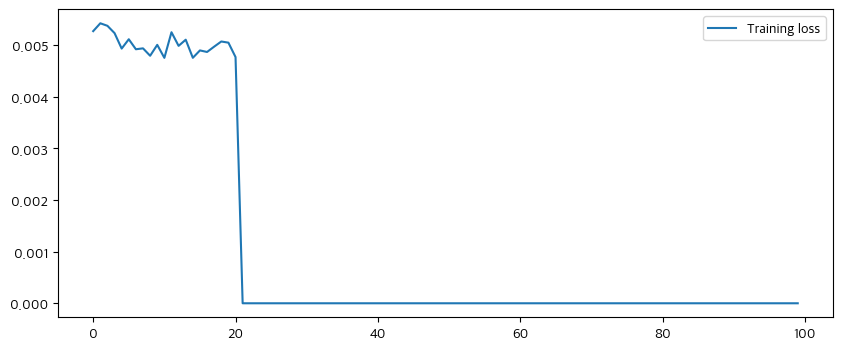

In [73]:
# epoch별 손실값
fig = plt.figure(figsize=(10, 4))
plt.plot(train_hist, label="Training loss")
plt.legend()
plt.show()

## 예측 데이터 시각화

In [74]:
# 텐서 형태로 데이터 정의
testset = TensorDataset(testX_tensor, testY_tensor)

# 데이터로더는 기본적으로 2개의 인자를 입력받으며 배치크기는 통상적으로 2의 배수를 사용
testloader = DataLoader(dataset,
                        batch_size=batch_size,
                        shuffle=False,
                        drop_last=True)

In [75]:
# 예측 테스트
avg_loss = 0.0
preds = []
labels = []

with torch.no_grad():
    ## TO-DO : make prediction and plot graph.
    for data in testloader:
        X_test, y_test = data[0].to(device), data[1].to(device)
        outputs = model(X_test)
        preds.append(outputs.cpu().tolist()) # 그래프를 그리기 위해서 데이터 변형
        labels.append(y_test.cpu().tolist()) # 그래프를 그리기 위해서 데이터 변형

        loss = criterion(outputs, y_test)
        avg_loss += loss

avg_loss = avg_loss / len(testloader)
print("Test MSE : %.4f" % avg_loss)

Test MSE : 0.0058


In [76]:
y_pred = [y_scaler.inverse_transform(pred) for pred in preds]
y_true = [y_scaler.inverse_transform(label) for label in labels]

In [77]:
y_pred = [y.reshape(-1, ) for y in y_pred]
y_true = [y.reshape(-1, ) for y in y_true]

In [78]:
_pred = []
_true = []
for y_hat, y in zip(y_pred, y_true):
    _pred += y_hat.tolist()
    _true += y.tolist()

print(_pred[:5], _true[:5])

[46989.62279558182, 47015.84526449442, 46785.3282019496, 45873.006200790405, 45613.544039428234] [43668.600411340594, 44693.41003745794, 42513.499139621854, 41649.339839071035, 44265.69461449981]


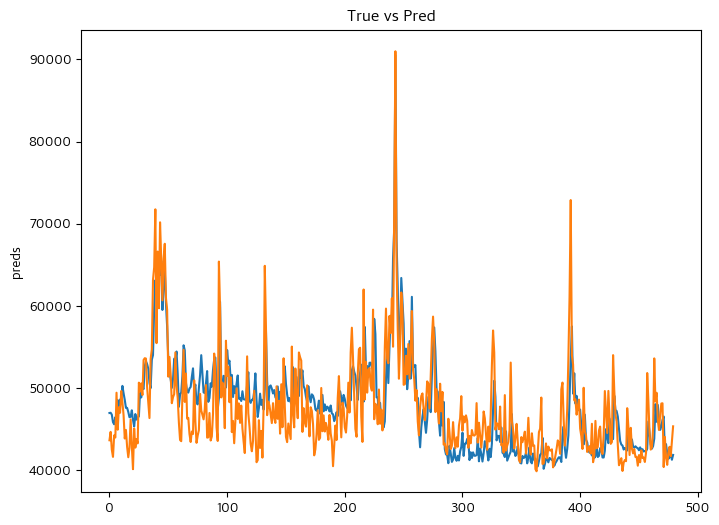

In [79]:
plt.figure(figsize=(8, 6))
df = pd.DataFrame({"preds" : _pred, "labels" : _true})
plt.title("True vs Pred")
sns.lineplot(df.preds)
sns.lineplot(df.labels)
plt.show()